# Leer las ondas
1) Imports

In [1]:
import psycopg2
from psycopg2.extensions import register_adapter, AsIs
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from oct2py import octave
#para el tiempo
from datetime import datetime
import pandas as pd
octave.addpath('/home/scidb/HeartRatePatterns/Matlab/')
octave.eval('pkg load signal')

Leer la base de datos para decidir que Ondas vamos a traer

In [2]:
def obtainWaveFormFields(dbname="mimic") :
    labels='II'
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    wave = "9393" #in (328,8932,9021,9036,9251,9393)
    select_stament = ("SELECT lef.subject_id,lef.recorddate,lef.signame,lef.fs "
                      " FROM waveformfields lef "
                      " LEFT JOIN (SELECT MAX(recorddate) AS recorddate,subject_id "
                      " FROM waveformFields GROUP BY subject_id) rig "
                      " ON lef.subject_id = rig.subject_id "
                      " AND lef.recorddate = rig.recorddate "
                      " WHERE rig.subject_id IS NOT NULL "
                      " AND signame @> ARRAY['"+labels+"']::varchar[] "
                      " AND lef.subject_id = "+wave)
    cur.execute(select_stament)
    waves = []
    for row in cur :
        patient = "p"+str(row[0]).zfill(6)
        onda = patient+'-'+row[1]
        carpeta = patient[:3]+"/"+patient
        waves.append({"subject_id":row[0],"recorddate":row[1],"fs":row[3],"onda":onda,"carpeta":carpeta,
                      "signalII":row[2].index("II")})
    conn.close()
    return waves

In [3]:
def notExistQRST(subject_id,recordDate,table="waveformQRST"):
    conn = psycopg2.connect("dbname=mimic")
    cur = conn.cursor()
    select_stament = 'select id from '+table+' where subject_id= %s and recorddate = %s'
    cur.execute(select_stament,(int(subject_id),recordDate))
    exist = cur.fetchone() is None
    conn.close()
    return exist

In [4]:
waves = obtainWaveFormFields()
wave = waves[0]
carpeta = wave["carpeta"]
onda = wave["onda"]
signalII = wave["signalII"]
fs = wave["fs"]
subject_id = wave["subject_id"]
recorddate = wave["recorddate"]
if notExistQRST(subject_id,recorddate) :
    signal = wfdb.rdsamp(onda,pbdir='mimic3wdb/matched/'+carpeta,channels =[signalII]).p_signals


In [5]:
def updateSignal(subject_id,recorddate,signallen,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    update_stament = "UPDATE waveformfields SET signallength=(%s) WHERE subject_id = (%s) AND recorddate = (%s)"
    cur.execute(update_stament,(signallen,subject_id,recorddate))
    conn.commit()

In [6]:
def subSignal(signal) :
    signalNan = signal[~np.isnan(signal)]
    signalSize = 1800000
    print("La señal tiene ",len(signalNan)," registros extraemos las ultimas 4 horas")
    if len(signalNan)<signalSize :
        subsignal = signalNan
    else :
        subsignal = signalNan[-1800000:]
    return subsignal.tolist()

In [7]:
updateSignal(subject_id,recorddate,len(signal))
subsignal = subSignal(signal)
len(subsignal)
#subsignal[1001500:1002000]

La señal tiene  118762264  registros extraemos las ultimas 4 horas


1800000

Extraemos las ultimas 4 horas osea 1'800.000 registros

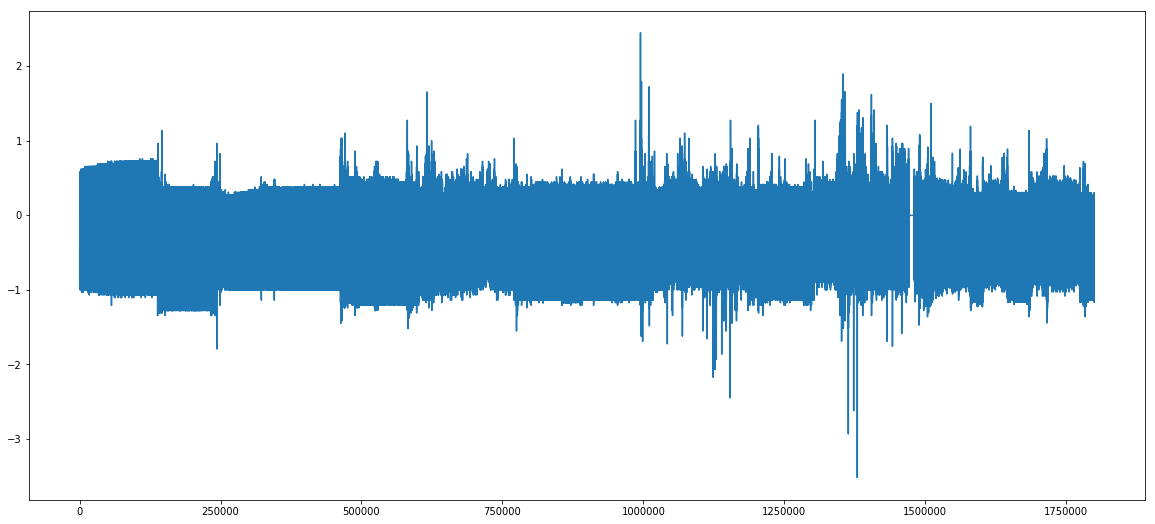

In [8]:
fig_size = [20,9]
plt.rcParams["figure.figsize"] = fig_size
plt.plot(subsignal)
#plt.plot(signal[:,1])
plt.show()

In [9]:
def peakdetect(signal, fs,increment=0,previousResult=None):
    if previousResult is None:
        previousResult = {'Q_i':[],'Q_amp':[],'R_i':[],'R_amp':[],'S_i':[],'S_amp':[],'T_i':[],'T_amp':[]}
    (R_i,R_amp,S_i,S_amp,T_i,T_amp,Q_i,Q_amp,heart_rate,buffer_plot) = octave.peakdetect(signal,fs,False, nout=10)
#    %octave [R_i,R_amp,S_i,S_amp,T_i,T_amp,Q_i,Q_amp,heart_rate,buffer_plot] = peakdetect(signal,fs,false); -i signal,fs -o R_i,R_amp,S_i,S_amp,T_i,T_amp,Q_i,Q_amp,heart_rate,buffer_plot
    return {'Q_i'  :np.concatenate((previousResult['Q_i'],  Q_i[0]+increment)),
            'Q_amp':np.concatenate((previousResult['Q_amp'],Q_amp[0])),
            'R_i'  :np.concatenate((previousResult['R_i'],  R_i[0]+increment)),
            'R_amp':np.concatenate((previousResult['R_amp'],R_amp[0])),
            'S_i'  :np.concatenate((previousResult['S_i'],  S_i[0]+increment)),
            'S_amp':np.concatenate((previousResult['S_amp'],S_amp[0])),
            'T_i'  :np.concatenate((previousResult['T_i'],  T_i[0]+increment)),
            'T_amp':np.concatenate((previousResult['T_amp'],T_amp[0])),
           }

In [10]:
def audit(before=datetime.now()):
    now = datetime.now()
    print("hasta aqui van",(now-before))
    return now

def checkwave(signal,fs):
    now = audit()
    windowsize = 4000*fs
    signalsize = len(signal)
    previousResult = {'Q_i':[],'Q_amp':[],'R_i':[],'R_amp':[],'S_i':[],'S_amp':[],'T_i':[],'T_amp':[]}
    termino = True
    fin=0
    while termino:
        ini=fin
        fin=fin+ (windowsize)
        if(fin>signalsize):
            fin=signalsize
        now = audit(now)
        print("ini",ini,"fin",fin)
        previousResult = peakdetect(signal[ini:fin],fs,increment=ini,previousResult=previousResult)
        now = audit(now)
        termino = fin<signalsize
    return previousResult

In [11]:
previousResult = checkwave(subsignal,fs)

hasta aqui van 0:00:00.015674
hasta aqui van 0:00:00.001025
ini 0 fin 500000
hasta aqui van 0:09:07.276310
hasta aqui van 0:00:00.000278
ini 500000 fin 1000000
hasta aqui van 0:07:33.725968
hasta aqui van 0:00:00.000597
ini 1000000 fin 1500000
hasta aqui van 0:09:20.944113
hasta aqui van 0:00:00.000394
ini 1500000 fin 1800000
hasta aqui van 0:03:47.224443


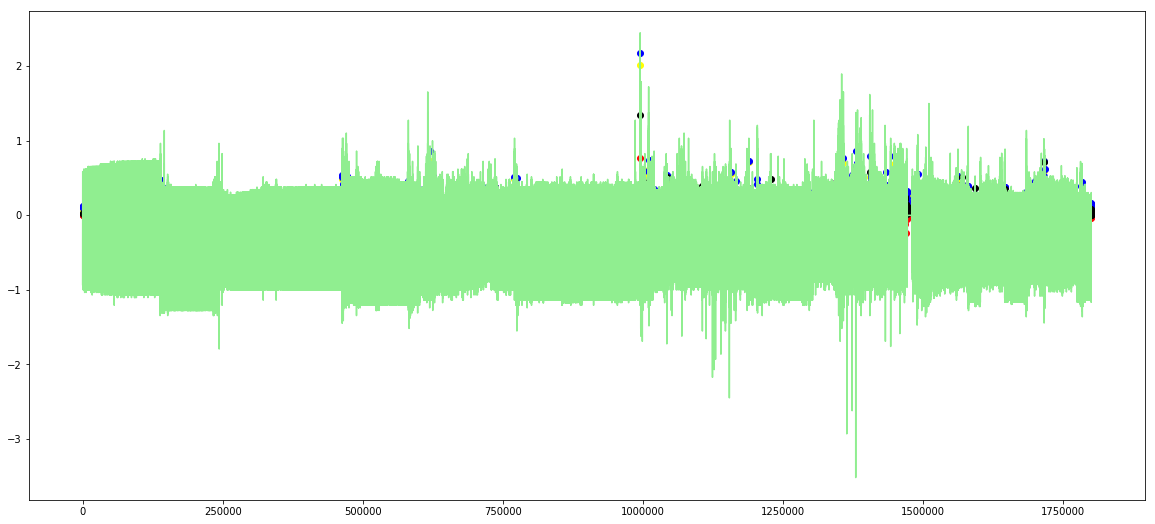

In [12]:
plt.scatter(previousResult['Q_i'], previousResult['Q_amp'],c='yellow')
plt.scatter(previousResult['R_i'], previousResult['R_amp'],c='blue')
plt.scatter(previousResult['S_i'], previousResult['S_amp'],c='red')
plt.scatter(previousResult['T_i'], previousResult['T_amp'],c='black')
plt.plot(subsignal,c='lightgreen')
plt.show()

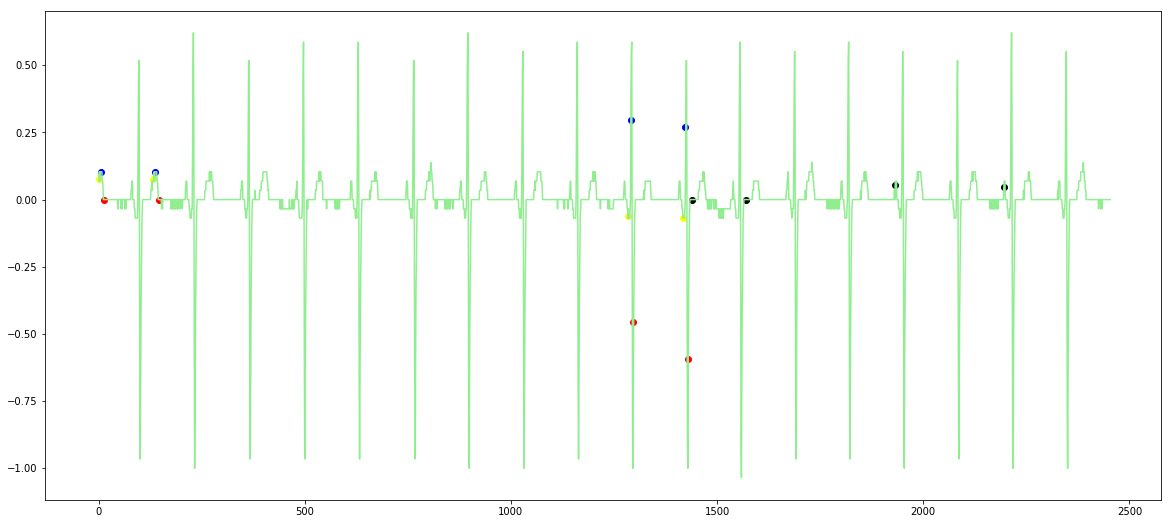

In [13]:
init = 6
end = 10
plt.plot(subsignal[int(previousResult['Q_i'][init]):int(previousResult['T_i'][end])],c='lightgreen')
plt.scatter(previousResult['Q_i'][init:end]-int(previousResult['Q_i'][init]), previousResult['Q_amp'][init:end],c='yellow')
plt.scatter(previousResult['R_i'][init:end]-int(previousResult['Q_i'][init]), previousResult['R_amp'][init:end],c='blue')
plt.scatter(previousResult['S_i'][init:end]-int(previousResult['Q_i'][init]), previousResult['S_amp'][init:end],c='red')
plt.scatter(previousResult['T_i'][init:end]-int(previousResult['Q_i'][init]), previousResult['T_amp'][init:end],c='black')
plt.show()

In [14]:
print('Q',len(previousResult['Q_i']), len(previousResult['Q_amp']))
print('R',len(previousResult['R_i']), len(previousResult['R_amp']))
print('S',len(previousResult['S_i']), len(previousResult['S_amp']))
print('T',len(previousResult['T_i']), len(previousResult['T_amp']))

Q 12895 12895
R 12895 12895
S 12894 12894
T 9761 9761


In [15]:
def readsignal(next1,next2,next3,wave,amp,i,signal) :
    currentw = int(signal[wave][i]) if len(signal[wave])>i else None
    if currentw is None or (next2 is not None and currentw>next2) or (next3 is not None and currentw>next3):
        return None,None,i
    if(next1 is None or currentw<=next1) :
        currentw,waveamp,i = currentw,signal[amp][i],i+1
    else :
        currentw,waveamp = None,None
    return currentw,waveamp,i
def sortHeartBeats(signal,originalSignal) :
    q,s,t,r,result = 0,0,0,0,None
    index = 0
    while q<len(signal['Q_i']) and r<len(signal['R_i']) and s<len(signal['S_i'])  and t<len(signal['T_i']) :
        rinext = signal['R_i'][r]   if r  <len(signal['R_i']) else None
        sinext = signal['S_i'][s]   if s  <len(signal['S_i']) else None
        tinext = signal['T_i'][t]   if t  <len(signal['T_i']) else None
        qinext = signal['Q_i'][q+1] if q+1<len(signal['Q_i']) else None
        riNext = signal['R_i'][q+1] if q+1<len(signal['R_i']) else None
        siNext = signal['S_i'][q+1] if q+1<len(signal['S_i']) else None
        
        qi,qamp,q = readsignal(rinext,sinext,tinext,'Q_i','Q_amp',q,signal)
        ri,ramp,r = readsignal(sinext,tinext,qinext,'R_i','R_amp',r,signal)
        si,samp,s = readsignal(tinext,qinext,riNext,'S_i','S_amp',s,signal)
        ti,tamp,t = readsignal(qinext,riNext,siNext,'T_i','T_amp',t,signal)
        if qi is not None and ti is not None :
            wave = originalSignal[int(qi):int(ti)]
        else :
            wave = None
      #  print("q",q,"r",r,"s",s,"t",t,"wave",wave)
        dic = {'Q_i':qi,'Q_amp':qamp,
               'R_i':ri,'R_amp':ramp,
               'S_i':si,'S_amp':samp,
               'T_i':ti,'T_amp':tamp,
              'wave':[wave]}
        if result is None :
            result = pd.DataFrame(dic, index=[index])
        else :
            result = pd.concat([result,  pd.DataFrame(dic, index=[index])])
        index=index+1
    return result
sortBeats = sortHeartBeats(previousResult,subsignal)

In [16]:
def checkQRST(qrst) :
    shape = qrst.shape[0]
    x = 0
    while x<shape :
        qiNotNone = qrst.iloc[x]["Q_i"] is not None
        riNotNone = qrst.iloc[x]["R_i"] is not None
        siNotNone = qrst.iloc[x]["S_i"] is not None
        tiNotNone = qrst.iloc[x]["T_i"] is not None
        if(qiNotNone and riNotNone and qrst.iloc[x]["Q_i"]>qrst.iloc[x]["R_i"]) :
            print("Q>R en",x)
        if(riNotNone and siNotNone and qrst.iloc[x]["R_i"]>qrst.iloc[x]["S_i"]) :
            print("R>S en",x)
        if(siNotNone and tiNotNone and qrst.iloc[x]["S_i"]>qrst.iloc[x]["T_i"]) :
            print("S>T en",x)
        if(qiNotNone and tiNotNone and qrst.iloc[x]["Q_i"]>qrst.iloc[x]["T_i"]) :
            print("Q>T en",x)
        x=x+1
checkQRST(sortBeats)

In [17]:
print(sortBeats.iloc[2112:2114])

         Q_amp     Q_i      R_amp     R_i S_amp     S_i     T_amp     T_i  \
2112  0.089655  264749   0.124138  264754     0  264763  0.041379  264811   
2113  0.062069  264861  0.0758621  264866     0  264873       NaN    None   

                                                   wave  
2112  [0.10344827586206896, 0.06896551724137931, 0.1...  
2113                                               None  


In [18]:
def addapt_numpy_float64(numpy_float64):
  return AsIs(numpy_float64)
register_adapter(np.float64, addapt_numpy_float64)
def addapt_numpy_int64(numpy_int64):
  return AsIs(numpy_int64)
register_adapter(np.int64, addapt_numpy_int64)

In [19]:
sortBeats = sortBeats.assign(subject_id=int(subject_id)).assign(recorddate=recorddate)
sortBeats['qrtsorder'] = sortBeats.index
def saveQRST(qrst) :
    conn = psycopg2.connect("dbname=mimic")
    cur = conn.cursor()
    table = "waveformQRST"
    cur.execute("CREATE TABLE IF NOT EXISTS "+table+
            " (id serial PRIMARY KEY,"+
            "Q_amp real,"+
            "Q_i integer,"+
            "R_amp real,"+
            "R_i integer,"+
            "S_amp real,"+
            "S_i integer,"+
            "T_amp real,"+
            "T_i integer,"+
            "subject_id integer,recorddate character varying(255),qrtsorder integer,"+
            'CONSTRAINT "uniqueQRST" UNIQUE (subject_id, recorddate, qrtsorder));')
    insert_statement = 'insert into '+table+' (%s) values %s'
    for index, row in qrst.iterrows():
        columns = row.keys()
        values = [row[column] for column in columns]
        #print(cur.mogrify(insert_statement, (AsIs(','.join(columns)), tuple(values))))
        cur.execute(insert_statement, (AsIs(','.join(columns)), tuple(values)))
    conn.commit()
    conn.close()
saveQRST(sortBeats)